In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Input, MaxPooling2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow_hub as hub
from matplotlib.pyplot import imshow
import pathlib
from google.colab import drive
import zipfile
from google.colab import files
import keras.utils as image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import glob

In [ ]:
def create_df(directory):
    filepaths = glob.glob(os.path.join(directory, '*', '*.jpg'))  # Ubah ekstensi file sesuai dengan jenis file gambar Anda
    labels = [os.path.basename(os.path.dirname(filepath)) for filepath in filepaths]
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

# Path data
input_shape = (224, 224, 3)  # Ubah sesuai dengan ukuran input gambar Anda
batch_size = 32
num_classes = 6  # Ganti dengan jumlah kelas yang sesuai dengan dataset Anda

# Direktori untuk data pelatihan, data validasi, dan data uji di Google Drive
train_dir = '/content/drive/MyDrive/Skripsi/jeruk 1200/train'
val_dir = '/content/drive/MyDrive/Skripsi/jeruk 1200/validation'
test_dir = '/content/drive/MyDrive/Skripsi/jeruk 1200/test'

# Membuat DataFrame untuk data pelatihan, data validasi, dan data uji
train_df = create_df(train_dir)
val_df = create_df(val_dir)
test_df = create_df(test_dir)

# Menampilkan jumlah data dalam setiap DataFrame
print("Jumlah data pelatihan:", len(train_df))
print("Jumlah data validasi:", len(val_df))
print("Jumlah data uji:", len(test_df))

Jumlah data pelatihan: 1200
Jumlah data validasi: 120
Jumlah data uji: 60


In [ ]:
def load_and_preprocess_data(train_dir, val_dir, test_dir, input_shape, batch_size):
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator()

    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

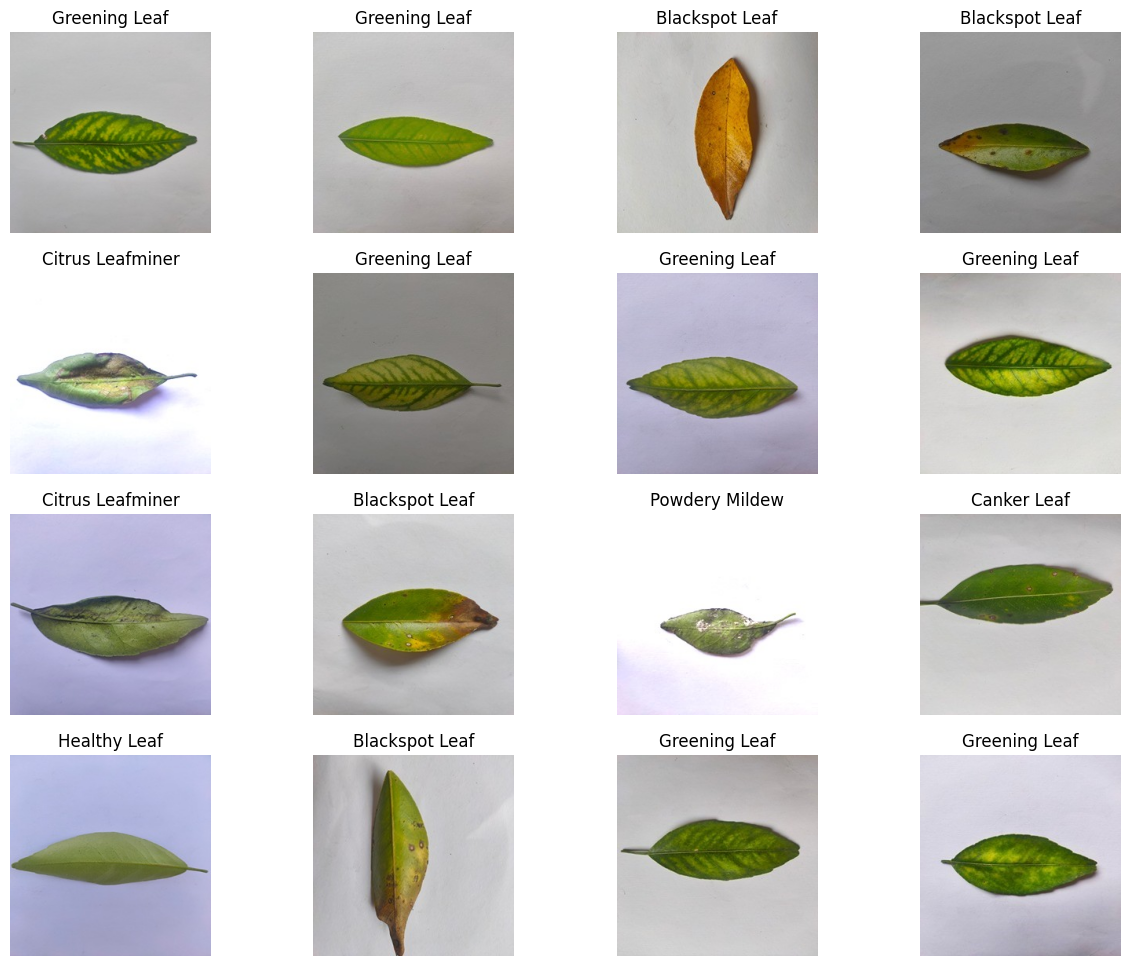

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_from_df(df, num_images=16):
    plt.figure(figsize=(15, 12))
    for i, (index, row) in enumerate(df.sample(num_images).iterrows()):
        plt.subplot(4, 4, i + 1)
        image_path = row['filepaths']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(row['labels'])
        plt.axis('off')
    plt.show()

# Contoh penggunaan:
plot_images_from_df(train_df)  # Menampilkan gambar dari DataFrame train_df

In [ ]:
# Load pre-trained EfficientNetB0 model
efficientnet_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
for layer in efficientnet_model.layers:
    layer.trainable = False

# Add custom layers on top of EfficientNet
x = efficientnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
predictions = Dense(6, activation='softmax')(x)


# Combine EfficientNet base model with custom layers
efficientnet = Model(inputs=efficientnet_model.input, outputs=predictions)

# Print model summary
efficientnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
efficientnet.compile(optimizer=RMSprop(learning_rate=0.00001),  loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Get Generators with adjusted batch size
batch_size = 32
train_gen, valid_gen, test_gen = load_and_preprocess_data(train_dir, val_dir, test_dir, input_shape, batch_size)

history = efficientnet.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=50,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size
)

Found 1200 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/50
37/37 [==============================] - 45s 759ms/step - loss: 9.1692 - accuracy: 0.2149 - val_loss: 9.0577 - val_accuracy: 0.2812
Epoch 2/50
37/37 [==============================] - 22s 582ms/step - loss: 9.0202 - accuracy: 0.2765 - val_loss: 8.9038 - val_accuracy: 0.3229
Epoch 3/50
37/37 [==============================] - 20s 539ms/step - loss: 8.8800 - accuracy: 0.3245 - val_loss: 8.7775 - val_accuracy: 0.4583
Epoch 4/50
37/37 [==============================] - 22s 595ms/step - loss: 8.7261 - accuracy: 0.4247 - val_loss: 8.6536 - val_accuracy: 0.5417
Epoch 5/50
37/37 [==============================] - 20s 548ms/step - loss: 8.6297 - accuracy: 0.4452 - val_loss: 8.5210 - val_accuracy: 0.5938
Epoch 6/50
37/37 [==============================] - 20s 536ms/step - loss: 8.5101 - accuracy: 0.4940 - val_loss: 8.4113 - val_accuracy: 0.6146
Epoch 7/50
37/37 [=

In [ ]:
def evaluate_model(efficientnet, train_generator, validation_generator, test_generator):
    # Evaluating the model on training data
    print("Training Data Evaluation:")
    train_evaluation = efficientnet.evaluate(train_generator)
    print("Loss:", train_evaluation[0])
    print("Accuracy:", train_evaluation[1])

    # Evaluating the model on validation data
    print("\nValidation Data Evaluation:")
    validation_evaluation = efficientnet.evaluate(validation_generator)
    print("Loss:", validation_evaluation[0])
    print("Accuracy:", validation_evaluation[1])

    # Evaluating the model on test data
    print("\nTest Data Evaluation:")
    test_evaluation = efficientnet.evaluate(test_generator)
    print("Loss:", test_evaluation[0])
    print("Accuracy:", test_evaluation[1])

# Memanggil fungsi evaluate_model dengan model dan generator untuk data pelatihan (train), validasi, dan test
evaluate_model(efficientnet, train_gen, valid_gen, test_gen)

Training Data Evaluation:
38/38 [==============================] - 22s 583ms/step - loss: 5.0265 - accuracy: 0.8950
Loss: 5.02645206451416
Accuracy: 0.8949999809265137

Validation Data Evaluation:
4/4 [==============================] - 3s 849ms/step - loss: 5.1452 - accuracy: 0.8500
Loss: 5.145193099975586
Accuracy: 0.8500000238418579

Test Data Evaluation:
2/2 [==============================] - 3s 2s/step - loss: 5.1794 - accuracy: 0.8333
Loss: 5.179384231567383
Accuracy: 0.8333333134651184


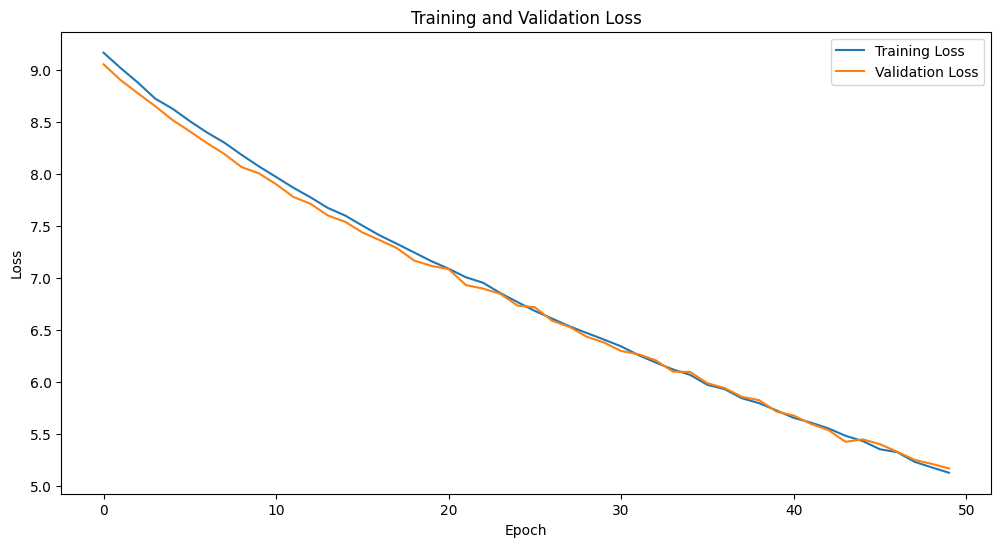

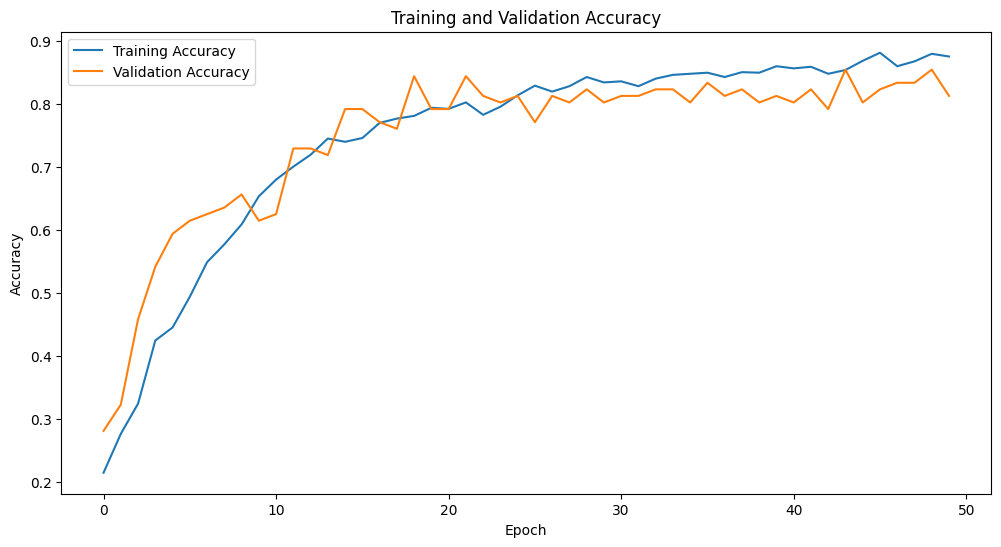

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Menyimpan metrik dari objek history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Membuat plot untuk loss
    plt.figure(figsize=(12, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Membuat plot untuk akurasi
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Memanggil fungsi plot_history dengan parameter objek history dari pelatihan model
plot_history(history)

2/2 [==============================] - 3s 177ms/step


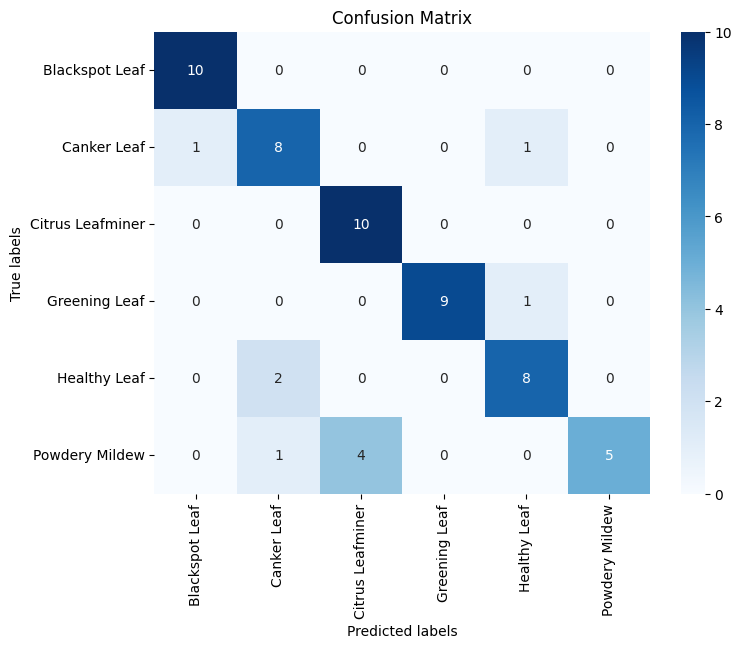

Classification Report:
                  precision    recall  f1-score   support

  Blackspot Leaf       0.91      1.00      0.95        10
     Canker Leaf       0.73      0.80      0.76        10
Citrus Leafminer       0.71      1.00      0.83        10
   Greening Leaf       1.00      0.90      0.95        10
    Healthy Leaf       0.80      0.80      0.80        10
  Powdery Mildew       1.00      0.50      0.67        10

        accuracy                           0.83        60
       macro avg       0.86      0.83      0.83        60
    weighted avg       0.86      0.83      0.83        60



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_with_metrics(y_true, y_pred, class_labels):
    # Menampilkan confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Menampilkan classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

# Contoh penggunaan:
# Hitung prediksi dengan model pada data testing
y_true = test_gen.classes
y_pred = efficientnet.predict(test_gen).argmax(axis=-1)
class_labels = list(test_gen.class_indices.keys())

# Menampilkan confusion matrix dan nilai metrik
evaluate_model_with_metrics(y_true, y_pred, class_labels)

2/2 [==============================] - 0s 130ms/step


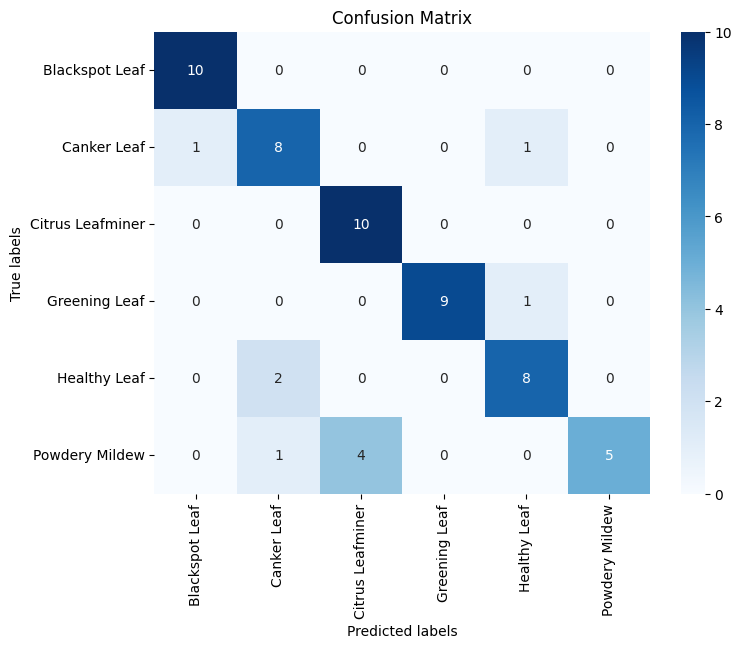

Filepath: /content/drive/MyDrive/Skripsi/jeruk 1200/test/Canker Leaf/Canker Leaf Test (10).jpg, True Label: Canker Leaf, Predicted Label: Healthy Leaf
Filepath: /content/drive/MyDrive/Skripsi/jeruk 1200/test/Canker Leaf/Canker Leaf Test (8).jpg, True Label: Canker Leaf, Predicted Label: Blackspot Leaf
Filepath: /content/drive/MyDrive/Skripsi/jeruk 1200/test/Greening Leaf/Greening Leaf Test (4).jpg, True Label: Greening Leaf, Predicted Label: Healthy Leaf
Filepath: /content/drive/MyDrive/Skripsi/jeruk 1200/test/Healthy Leaf/Healthy Leaf Test (4).jpg, True Label: Healthy Leaf, Predicted Label: Canker Leaf
Filepath: /content/drive/MyDrive/Skripsi/jeruk 1200/test/Healthy Leaf/Healthy Leaf Test (8).jpg, True Label: Healthy Leaf, Predicted Label: Canker Leaf
Filepath: /content/drive/MyDrive/Skripsi/jeruk 1200/test/Powdery Mildew/Powdery Mildew Test (2).jpg, True Label: Powdery Mildew, Predicted Label: Citrus Leafminer
Filepath: /content/drive/MyDrive/Skripsi/jeruk 1200/test/Powdery Mildew/Po

In [ ]:
from sklearn.metrics import confusion_matrix

# Hitung prediksi dengan model pada data uji
y_true = test_gen.classes
y_pred = efficientnet.predict(test_gen).argmax(axis=-1)

# Dapatkan confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Temukan indeks data yang salah diprediksi
misclassified_indices = np.where(y_true != y_pred)[0]

# Tampilkan data yang diprediksi salah
class_indices_inverted = {v: k for k, v in test_gen.class_indices.items()}  # Dictionary invers dari class_indices
for index in misclassified_indices:
    filepath = test_gen.filepaths[index]
    true_label_index = y_true[index]  # Dapatkan indeks kelas yang benar
    predicted_label_index = y_pred[index]  # Dapatkan indeks kelas yang diprediksi
    true_label = class_indices_inverted[true_label_index]  # Dapatkan label kelas yang benar
    predicted_label = class_indices_inverted[predicted_label_index]  # Dapatkan label kelas yang diprediksi
    print(f"Filepath: {filepath}, True Label: {true_label}, Predicted Label: {predicted_label}")

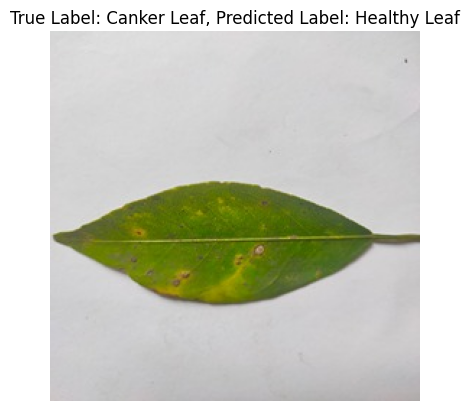

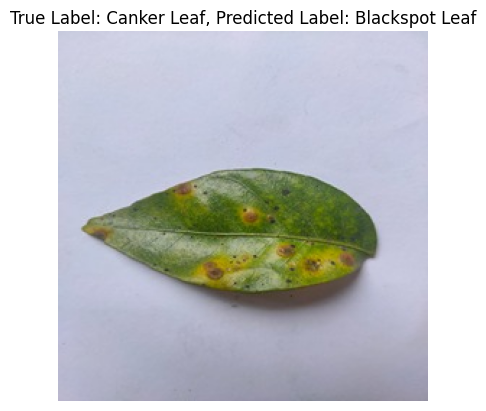

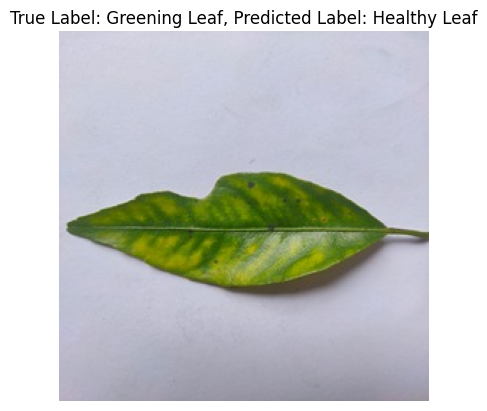

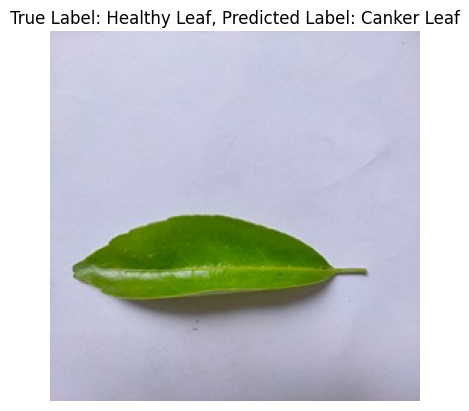

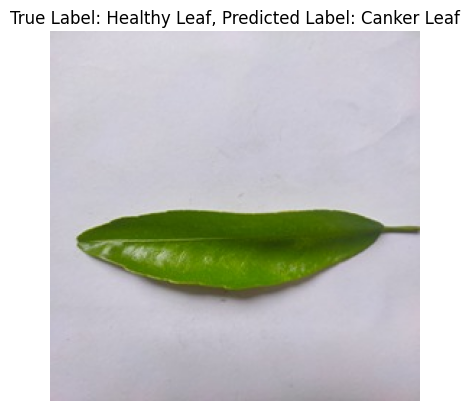

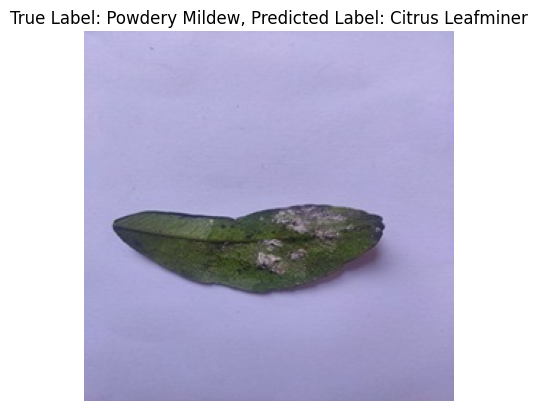

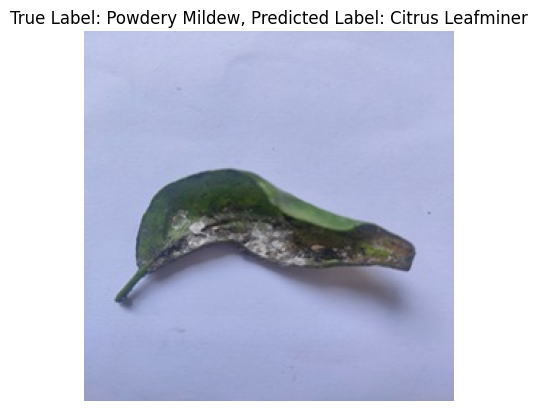

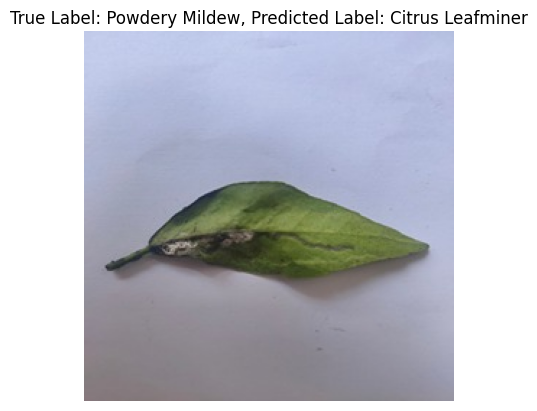

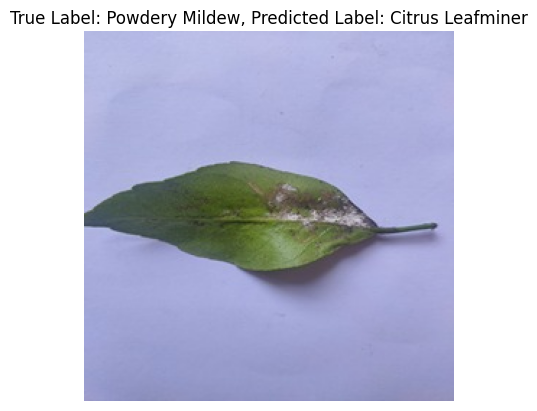

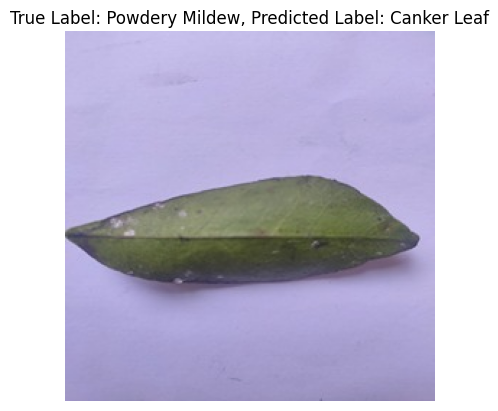

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Tampilkan data yang diprediksi salah
class_indices_inverted = {v: k for k, v in test_gen.class_indices.items()}  # Dictionary invers dari class_indices
for index in misclassified_indices:
    filepath = test_gen.filepaths[index]
    true_label_index = y_true[index]  # Dapatkan indeks kelas yang benar
    predicted_label_index = y_pred[index]  # Dapatkan indeks kelas yang diprediksi
    true_label = class_indices_inverted[true_label_index]  # Dapatkan label kelas yang benar
    predicted_label = class_indices_inverted[predicted_label_index]  # Dapatkan label kelas yang diprediksi

    # Tampilkan gambar
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

In [ ]:
# Import library yang diperlukan
from tensorflow.keras.models import save_model

# Path untuk menyimpan model H5
model_h5_path = '/content/drive/MyDrive/Skripsi/Skenario Pengujian/Coding Mandiri/EfficientNet/Pretrained/effnetb4_RMSprop(0.00001).h5'

# Simpan model ke file H5
save_model(efficientnet, model_h5_path)

print("Model berhasil disimpan sebagai model.h5 di lokasi yang Anda tentukan.")

<ipython-input-14-12d9657a0195>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(efficientnet, model_h5_path)


Model berhasil disimpan sebagai model.h5 di lokasi yang Anda tentukan.


In [ ]:
tf.keras.backend.clear_session()